In [1]:
import pickle
import numpy as np
import torch
import pandas as pd
from torch import nn

In [2]:
TRAIN = False

In [3]:
USE_YAM = True

In [4]:
FIL = 'utrs_embeddings_6_10_50'
if not USE_YAM:
    Y_ID = ''
    fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
else:
    Y_ID = 'YAM'
    data = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)
    data = data.loc[data.utr_seq.notna()]
    data = data.loc[data.gene.notna()]
    data.drop_duplicates(inplace = True)
    fDf = data[['gene', 'intensity', 'utr_seq']]
with open(f'../processed_data/{FIL}{Y_ID}.pkl', 'rb') as inp:
    [genes, tokenized, embedding_keys, embedding_mat] = pickle.load(inp)

checkpoint_path = f"../model/utrs_lstm_weights{Y_ID}.ckpt"
common_geneset = set(genes) & set(fDf['gene'])
seq_geneset_mask = [g in common_geneset for g in genes]
seq_geneset = [g for g in genes if g in common_geneset]
tokenized = [s for s,g in zip(tokenized, seq_geneset_mask) if g]
fDf = fDf.set_index('gene').loc[seq_geneset, :].reset_index()
mask = fDf['intensity'] > 0 # negative intensities make no sense
print(f"Removing {sum(~mask)} rows that have negative intensity")
fDf = fDf[mask]
tokenized = [x for m,x in zip(mask, tokenized) if m]
len(fDf), len(tokenized)

Removing 0 rows that have negative intensity


(5302, 5302)

In [5]:
fDf['logInt'] = np.log(fDf['intensity'])
maskLog = fDf['logInt']>-20
print(f"Removing {sum(~maskLog)} rows that have outliers log Intensity values <= -20")
fDf = fDf[fDf['logInt']>-20]
tokenized = [x for m,x in zip(maskLog, tokenized) if m]
y = fDf['logInt'].copy()
len(fDf), len(tokenized)

Removing 0 rows that have outliers log Intensity values <= -20


(5302, 5302)

In [6]:
y_dig = np.digitize(y, np.quantile(y, np.arange(0,1,0.2)))
mask0 = y_dig == 1
mask1 = y_dig == 5

mask = mask0 | mask1
x = [t for (t,m) in zip(tokenized,mask) if m]
y_bin = y_dig[mask] ==5
len(x), y_bin.shape[0]

(2122, 2122)

In [7]:
from tensorflow.keras.utils import to_categorical
from tensorflow.ragged import constant
import os
import tensorflow as tf

In [8]:
from tensorflow.keras.optimizers import Adam

In [9]:
# Tensorflow 1.9; Keras 2.2.0 (latest versions)
# should be backwards compatible upto Keras 2.0.9 and tf 1.5
from keras.models import Model
from keras.layers import *
import numpy as np
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
def create_models():
    #Get a sequence of indexes of words as input:
    # Keras supports dynamic input lengths if you provide (None,) as the 
    #  input shape
    inp = Input((None,))
    #Embed words into vectors of size 10 each:
    # Output shape is (None,10)
    
    embs = Embedding(embedding_mat.shape[0],
                            embedding_mat.shape[1],
                            weights=[embedding_mat],
                            trainable=False)(inp)
    dropout = SpatialDropout1D(0.2)(embs)
    # Run LSTM on these vectors and return output on each timestep
    # Output shape is (None,5)
    lstm = Bidirectional(LSTM(32, return_sequences=True))(dropout)
    ##Attention Block
    #Transform each timestep into 1 value (attention_value) 
    # Output shape is (None,1)
    attention = TimeDistributed(Dense(1))(lstm)
    #By running softmax on axis 1 we force attention_values
    # to sum up to 1. We are effectively assigning a "weight" to each timestep
    # Output shape is still (None,1) but each value changes
    attention_vals = Softmax(axis=1, dtype='float32')(attention)
    # Multiply the encoded timestep by the respective weight
    # I.e. we are scaling each timestep based on its weight
    # Output shape is (None,5): (None,5)*(None,1)=(None,5)
    scaled_vecs = Multiply()([lstm,attention_vals])
    # Sum up all scaled timesteps into 1 vector 
    # i.e. obtain a weighted sum of timesteps
    # Output shape is (5,) : Observe the time dimension got collapsed
    context_vector = Lambda(lambda x: tf.keras.backend.sum(x,axis=1))(scaled_vecs)
    ##Attention Block over
    # Get the output out
    x = Dense(1)(context_vector)
    out = Activation('sigmoid', dtype='float32', name='predictions')(x)
    model = Model(inp, out)
    model_with_attention_output = Model(inp, [out, attention_vals])
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy', metrics=['accuracy'])
    return model, model_with_attention_output

model,model_with_attention_output = create_models()
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5


2021-12-04 03:33:52.999942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 03:33:53.005198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 03:33:53.005399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 03:33:53.006000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 03:33:53.014179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized wit

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     252450      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 50)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 64)     21248       ['spatial_dropout1d[0][0]']  

In [10]:
from keras.preprocessing.sequence import pad_sequences

In [11]:
if TRAIN:
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x, y_bin, test_size=0.1)
    y_train.shape, y_valid.shape

In [12]:
if TRAIN:
    seq_len = max([len(x) for x in x_train])
    seq_len

In [13]:
if TRAIN:
    padded = pad_sequences(x_train,seq_len,value=-1)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,save_best_only=True,
                                                     monitor='val_accuracy',
                                                     verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=0,
        mode='auto', baseline=None, restore_best_weights=False
    )
    history = model.fit(
    #     constant([np.array(t) for t in x_train],dtype='int16'),
        padded,
        np.array(y_train),
        batch_size=32, epochs=1000,
        callbacks=[cp_callback, es_callback],
        validation_data=(constant([np.array(t) for t in x_valid],dtype='int16'),
        np.array(y_valid)))


In [14]:
if TRAIN:
    with open(f'../model/training_history{Y_ID}.pkl', 'wb') as out:
        pickle.dump(history.history, out)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


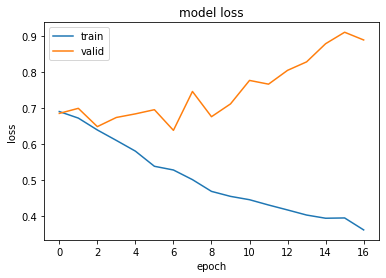

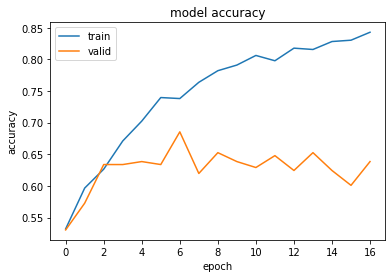

In [15]:
with open(f'../model/training_history{Y_ID}.pkl', 'rb') as inp:
    history= pickle.load(inp)
import matplotlib.pyplot as plt
# list all data in history
print(history.keys())
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [16]:
model_with_attention_output.load_weights(checkpoint_path)

In [17]:
words_importances_per_seq = model_with_attention_output.predict(constant([np.array(t) for t in tokenized],dtype='int16'),batch_size=128)[1]

In [18]:
words_importances_per_seq = words_importances_per_seq.numpy()

In [19]:
np.min([np.min(p) for p in words_importances_per_seq])

4.23913e-06

In [20]:
np.max([np.max(p) for p in words_importances_per_seq])

0.25198498

In [21]:
def reconstruct_sequence(ori_seq, sub_seqs, importances):
    unseen = ori_seq
    reconstructed_importances = np.zeros(len(ori_seq))
    t1 = 0
    t0 = 0
    den_vec = np.zeros(len(ori_seq))
    nom_vec = np.zeros(len(ori_seq))
    for i,s,e in zip(importances[:-1], sub_seqs[:-1], sub_seqs[1:]):
        t0 += t1
        t1 = unseen.find(e)
        # max is used to handle gaps created due to rounding errors in k-mer partitioning (among hits of interest)
        nom_vec[t0:t0 + max(t1, len(s))] += i
        den_vec[t0:t0 + max(t1, len(s))] += 1
        unseen = unseen[t1:]
    nom_vec[-len(sub_seqs[-1]):] += importances[-1]
    den_vec[-len(sub_seqs[-1]):] += 1
    
    reconstructed_importances = nom_vec/den_vec
    return reconstructed_importances

In [22]:
def plotSignature(ind):
    print('Gene:', fDf.iloc[ind]['gene'])
    p = reconstruct_sequence(fDf.iloc[ind]['utr_seq'], np.array(embedding_keys)[tokenized[ind]], words_importances_per_seq[ind])
    plt.figure(figsize=(60,5))
    plt.plot(p)
    _=plt.xticks(np.arange(len(fDf.iloc[ind]['utr_seq'])), list(fDf.iloc[ind]['utr_seq']))

Gene: AI1


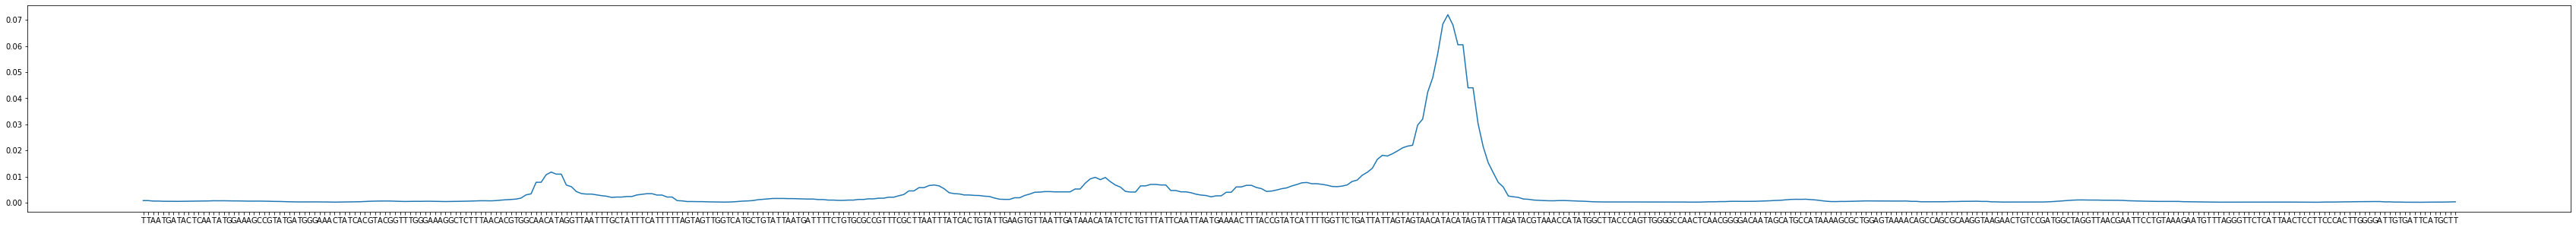

In [23]:
plotSignature(0)

Gene: AI2


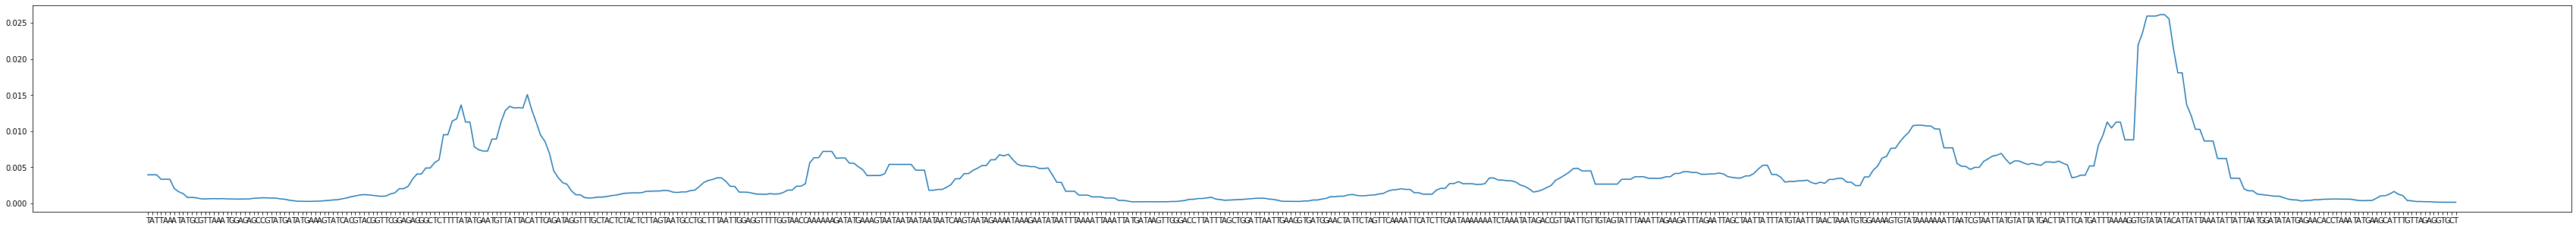

In [24]:
plotSignature(1)

Gene: AI3


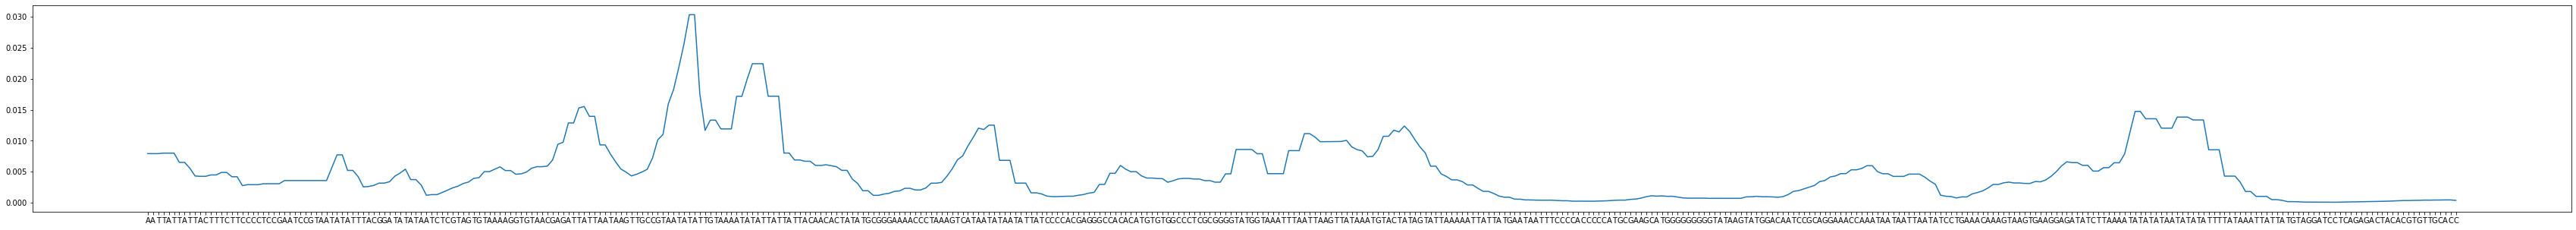

In [25]:
plotSignature(2)

Gene: TFC3


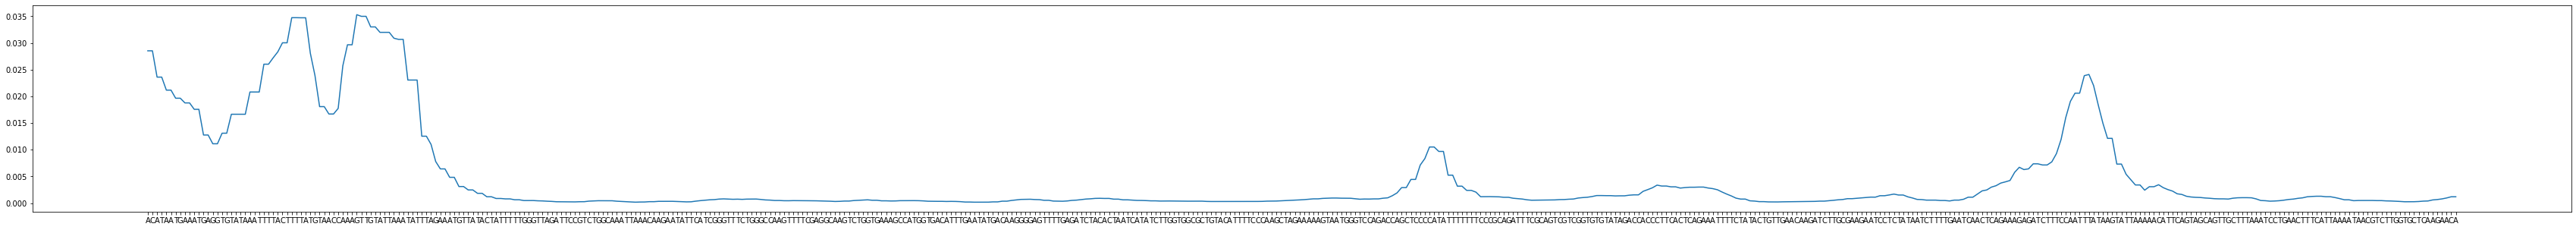

In [26]:
plotSignature(3)

Gene: VPS8


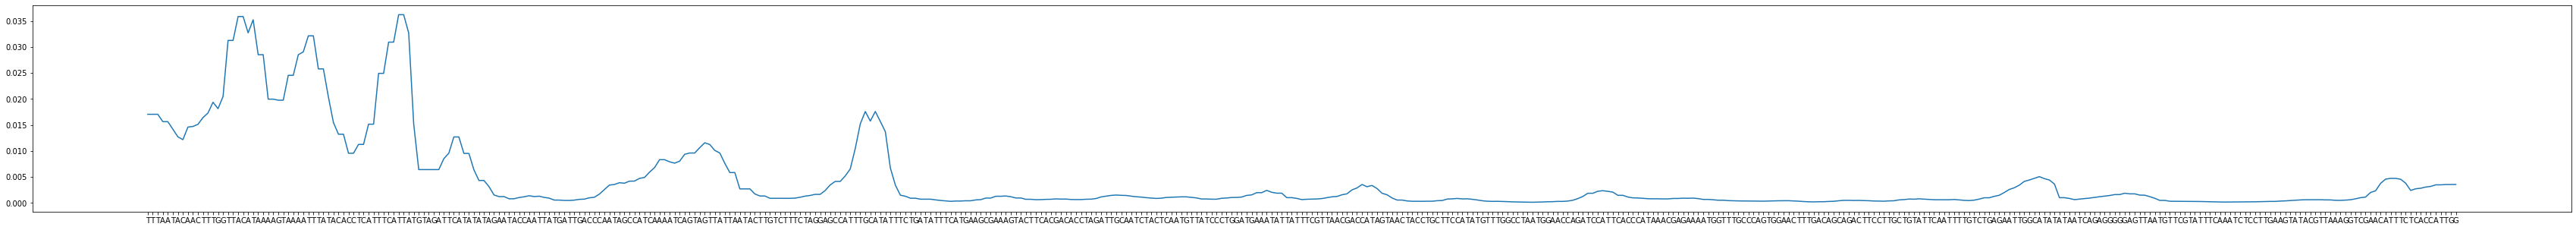

In [27]:
plotSignature(4)

Gene: SSA1


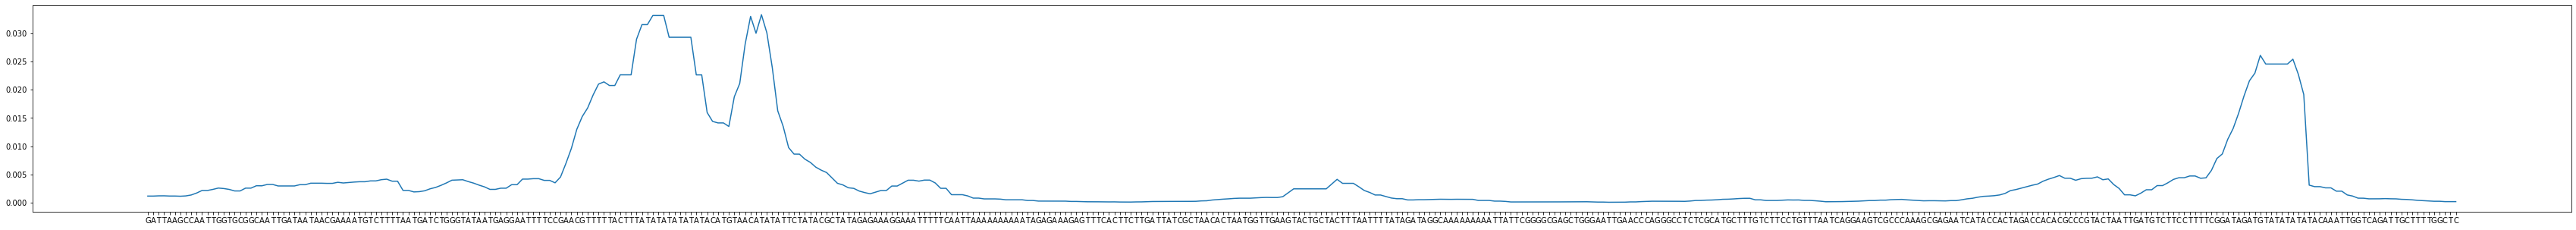

In [28]:
plotSignature(5)

Gene: ERP2


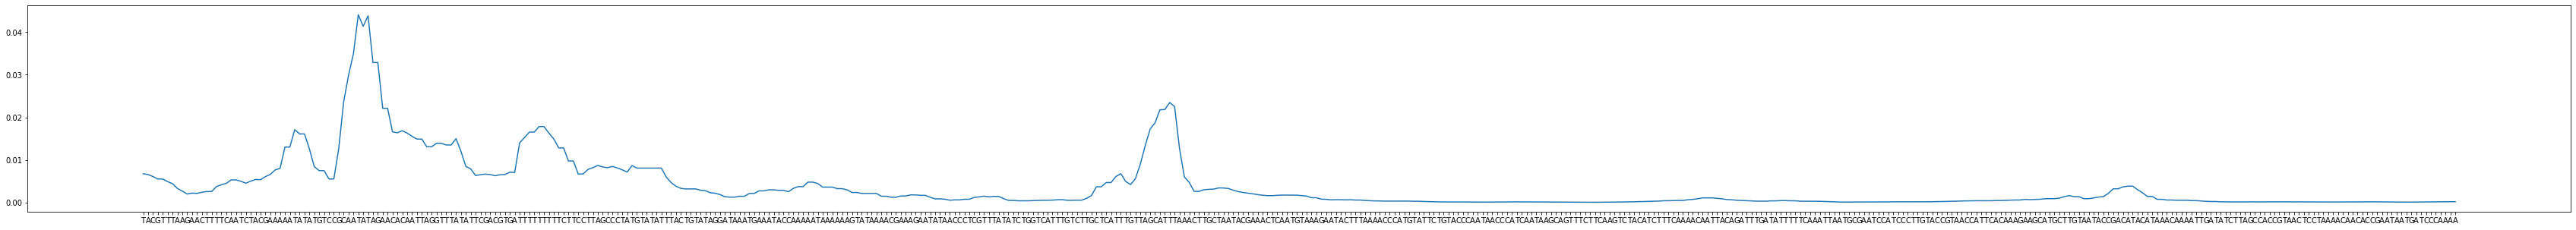

In [29]:
plotSignature(6)

Gene: FUN14


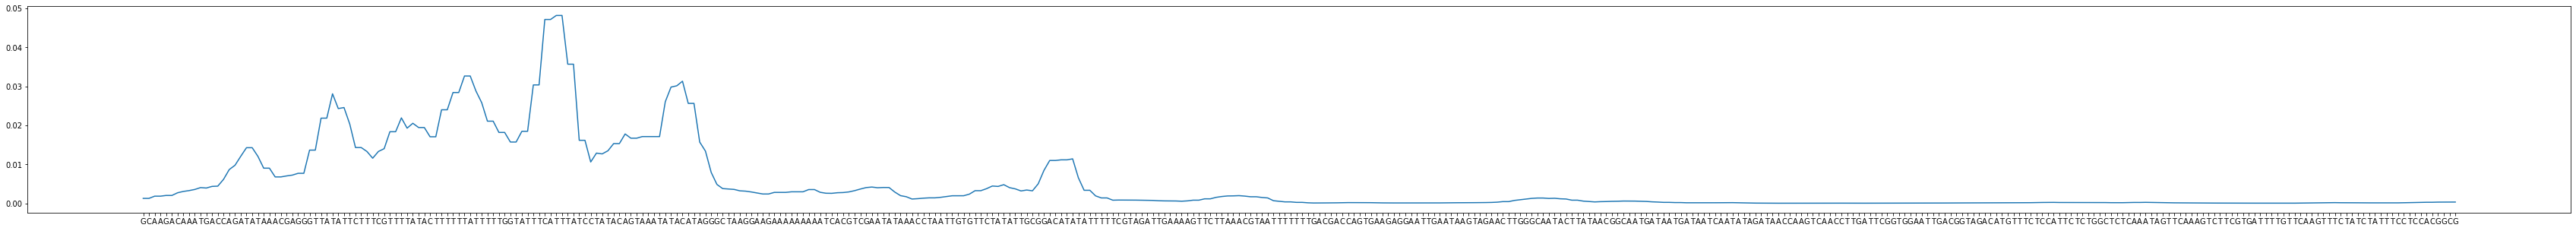

In [30]:
plotSignature(7)

Gene: SPO7


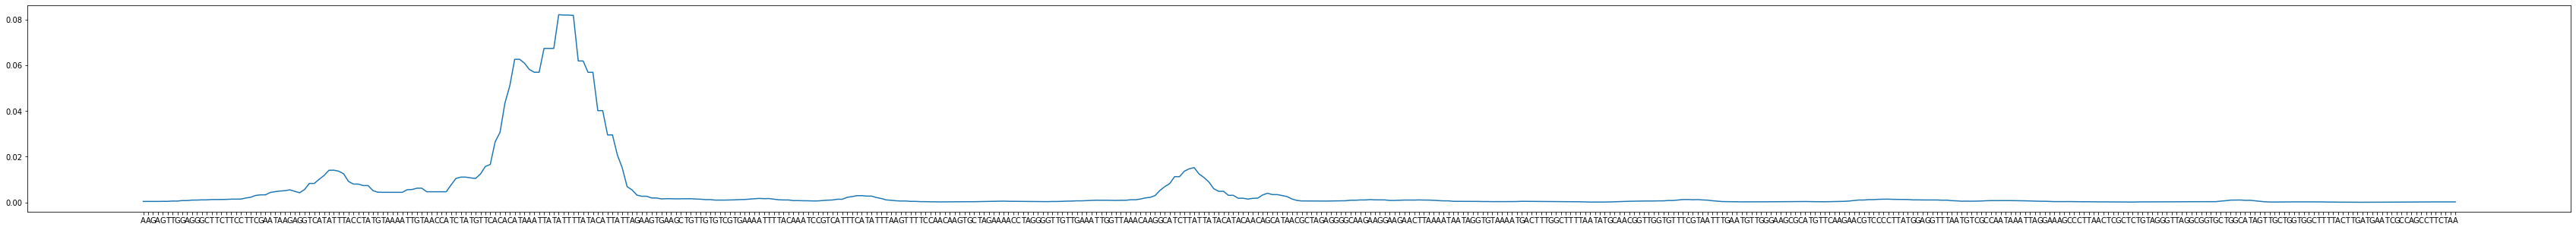

In [31]:
plotSignature(8)

In [32]:
top10i1 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==1])
top10i0 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==0])

### Most frequent k-mers appearing in the sequences that have been labelled with 1

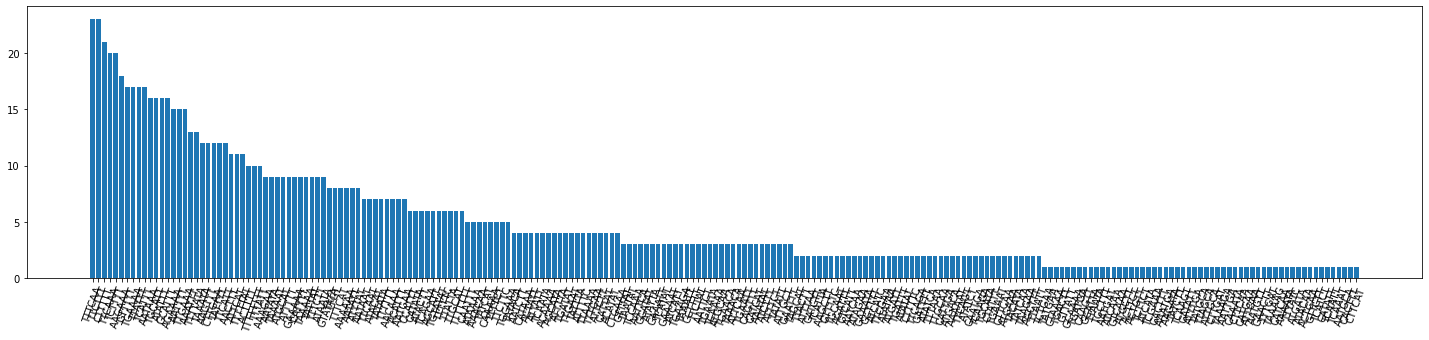

In [33]:
plt.figure(figsize=(25,5))
top1i1bins = np.bincount(top10i1[:,0])
top1i1inds = np.argsort(-top1i1bins)
top1i1inds = top1i1inds[top1i1bins[top1i1inds]>0]
plt.bar(np.array(embedding_keys)[top1i1inds], top1i1bins[top1i1inds],)
_=plt.xticks(rotation=70)

### Network architecture
Architecture defined by the awesome architect in https://stackoverflow.com/questions/51477977/highlighting-important-words-in-a-sentence-using-deep-learning/51481366 with the spatial dropout addition to cater for generalization

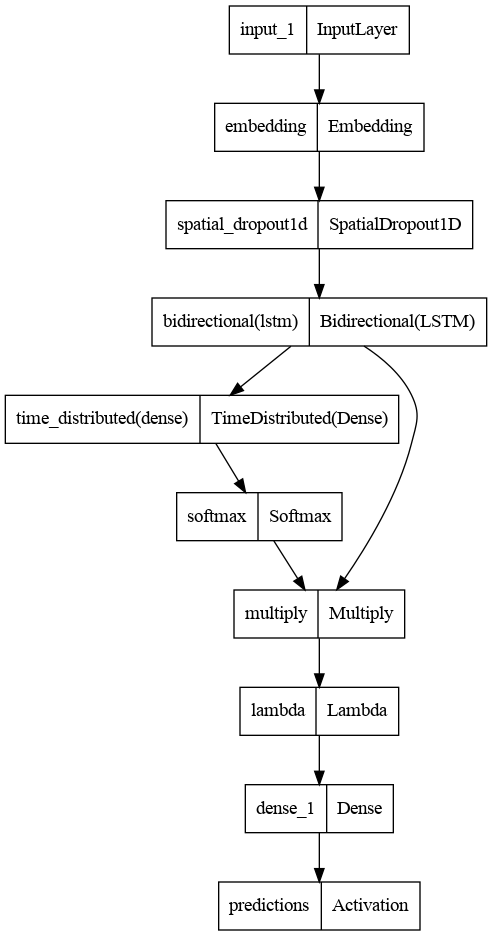

In [36]:
tf.keras.utils.plot_model(
    model, to_file='../figures/utrs_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)